In [1]:
# Python standard library imports
import os
import sys

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# JAX imports
import jax
from jax import numpy as jnp


# Hyperiax imports
import hyperiax
from hyperiax.execution import LevelwiseTreeExecutor, DependencyTreeExecutor
from hyperiax.models import UpLambda
from hyperiax.models.functional import pass_up

# Local imports
from help_functions.DICAROS import *
from help_functions.DICAROS_phylomorhpspace import *
from help_functions.align_shapes import *

In [2]:
# Load all files
corrected_dataset = "./Papilnodae_dataset/"


fline=open(corrected_dataset+"/tree.tree").readline().rstrip()
tree = hyperiax.tree.builders.tree_from_newick(fline)

tree.root.data["edge_length"] = 0

# variables
landmarks = pd.read_csv(corrected_dataset+"/mean_shapes.csv",)
metadata = pd.read_csv(corrected_dataset+"/metadata.csv")

# plot tree

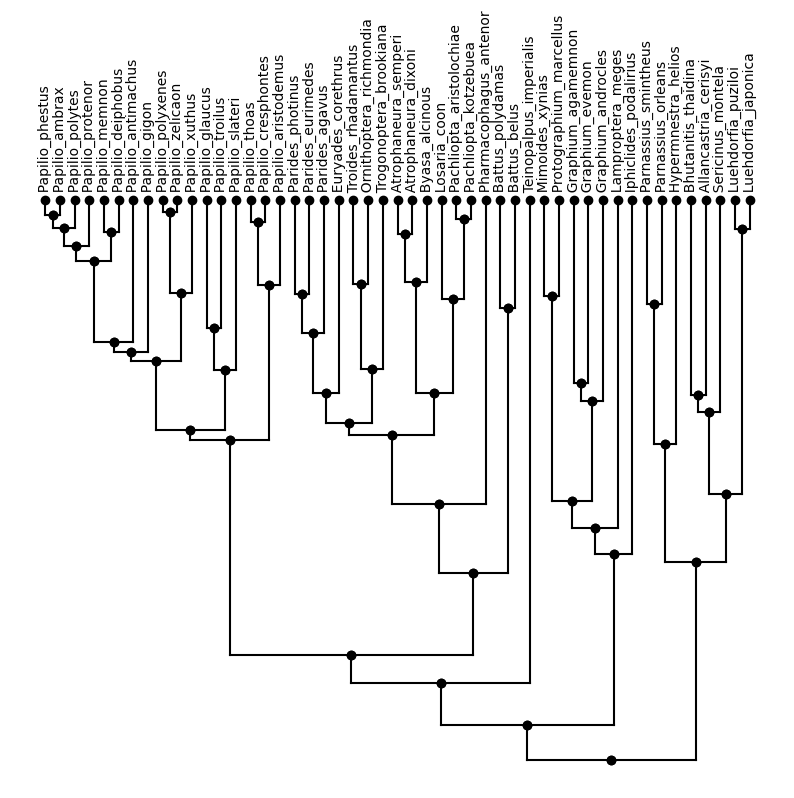

In [3]:
tree.plot_tree(inc_names=True)

In [4]:
landmarks["species"] = landmarks["species"].str.replace(" ", "_")
landmarks = landmarks.set_index('species')
landmarks = landmarks.drop(columns='count')

In [5]:
n,m = jnp.shape(landmarks)
d = 2

# Rearrange the landmarks to fit the tree
node_names = [node.name for node in tree.iter_leaves()]
landmarks = landmarks.loc[node_names]



In [6]:
# Allign shapes
# For each row in landmarks, convert to array 
gpa_landmarks = [row.reshape(-1,d) for row in landmarks.values]

aligned_shapes, final_mean_shape = align_shapes(gpa_landmarks, max_iterations=100)


In [7]:
for i, leaf in enumerate(tree.iter_leaves()):
    leaf.data["value"] = jnp.array(aligned_shapes[i].flatten())

# Plot shapes

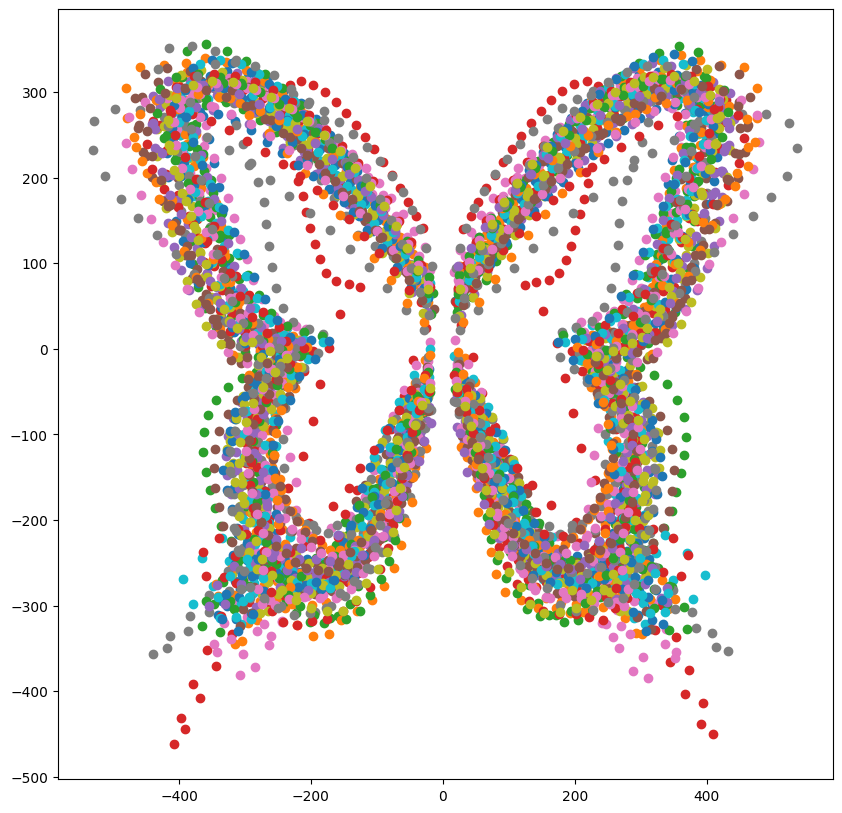

In [8]:
plt.figure(figsize=(10,10))
for i, leaf in enumerate(tree.iter_leaves()):
    plt.scatter(leaf.data["value"][::2], -leaf.data["value"][1::2])




In [9]:

# if gpu 

# Check if GPU is available
available_devices = jax.devices()
if any('gpu' in str(device).lower() for device in available_devices):
    # Use first available GPU
    gpu_selector = next(i for i, device in enumerate(available_devices) if 'gpu' in str(device).lower())
    selected_device = available_devices[gpu_selector]
    print(f"Using GPU device: {selected_device}")
else:
    # Use CPU if no GPU available
    selected_device = jax.devices('cpu')[0]
    print(f"No GPU found, using CPU device: {selected_device}")

# Compile the function for the selected device
fuse_lddmm = jax.jit(fuse_lddmm, device=selected_device)


up_momentum= pass_up('value','sigma','edge_length')
upmodel_momentum = UpLambda(up_momentum, fuse_lddmm)
root_exe_momentum = DependencyTreeExecutor(upmodel_momentum, batch_size=5)


# Compile the function for the second GPU
fuse_edgelength = jax.jit(fuse_edgelength, device=selected_device)
up_correct_edge= pass_up('edge_length')
upmodel_edge = UpLambda(up_correct_edge, fuse_edgelength)
root_exe_edgelength = DependencyTreeExecutor(upmodel_edge, batch_size=5)


No GPU found, using CPU device: TFRT_CPU_0


In [10]:
# Correct edge length to adjust for uncertiniaty 
tree = root_exe_edgelength.up(tree)


# estimate sigma
sigma = np.mean([find_sigma(node["value"]) for node in tree.iter_leaves()])
for leaf in tree.iter_bfs():
    leaf['sigma']=jnp.array([sigma]*d)

In [11]:
# Do reconstruction
tree = root_exe_momentum.up(tree)

#  Plot reconstructed root

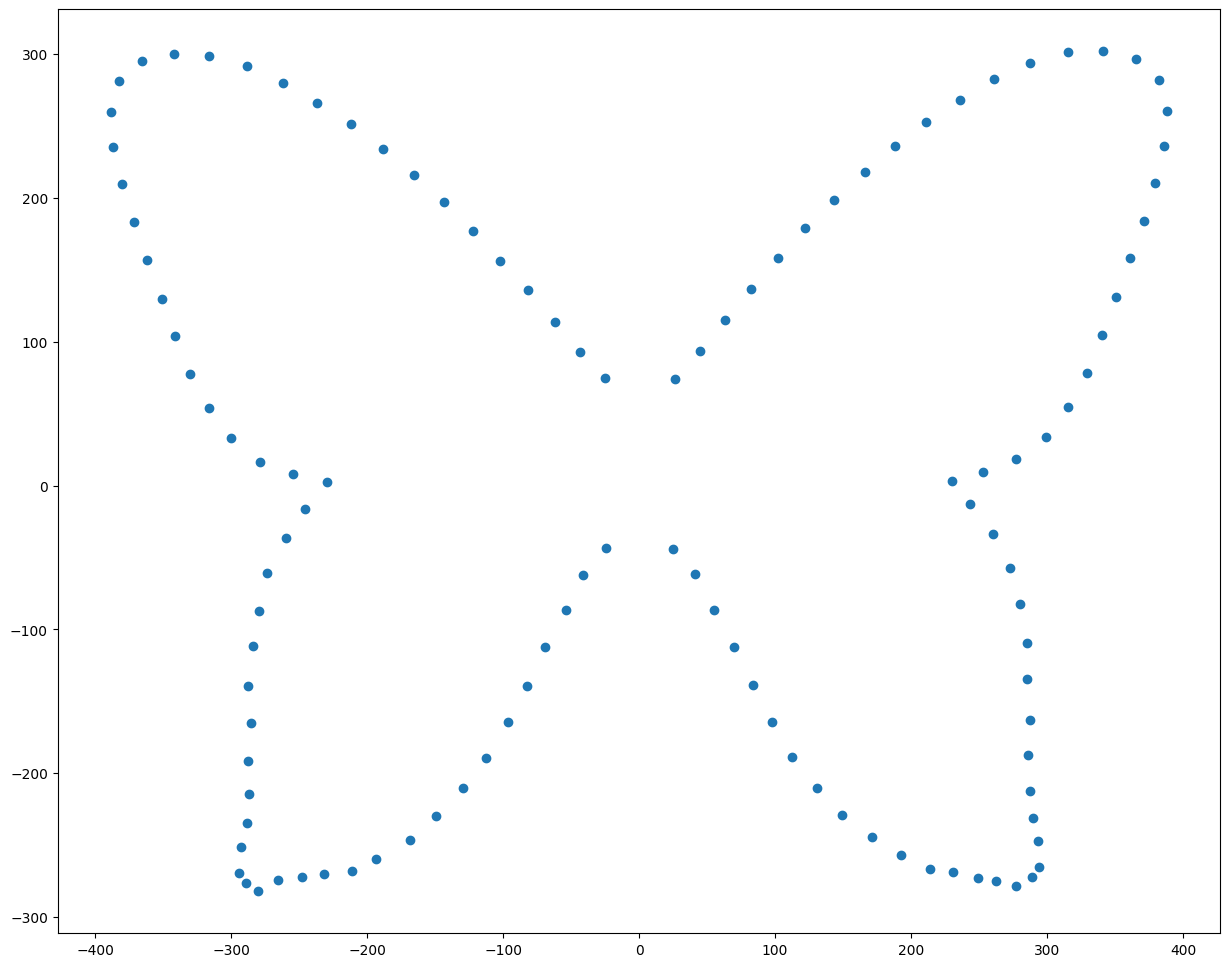

In [12]:
plt.scatter(tree.root.data["value"][::2], -tree.root.data["value"][1::2])


# Estimate PhyloMorphoSpace


In [13]:
# Lift all contrasts to the root 

n = int(len(leaf.data["value"])/d)
p_all = lift_p(tree, n)

varexp,x_projected = compute_pca_and_update_tree(tree, p_all, n, n_components=5)



In [14]:
# Add a variable for plotting only
for leaf in tree.iter_bfs():
    leaf.data["tailed"] = 0

tailing = [0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,0,2,1,1,1,1,0,0,1,0,2,0,0,2,2,1,0,0,0,2,1,2,0,1]

for i,leaf in enumerate(list((tree.iter_leaves_dfs()))):
    leaf.data["tailed"] = tailing[i]


# Plot results 

/tmp/ipykernel_73503/1632277427.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([leaf["PCs"][0], child["PCs"][0]], [leaf["PCs"][1], child["PCs"][1]], 'k-', linewidth=0.5,color="grey")


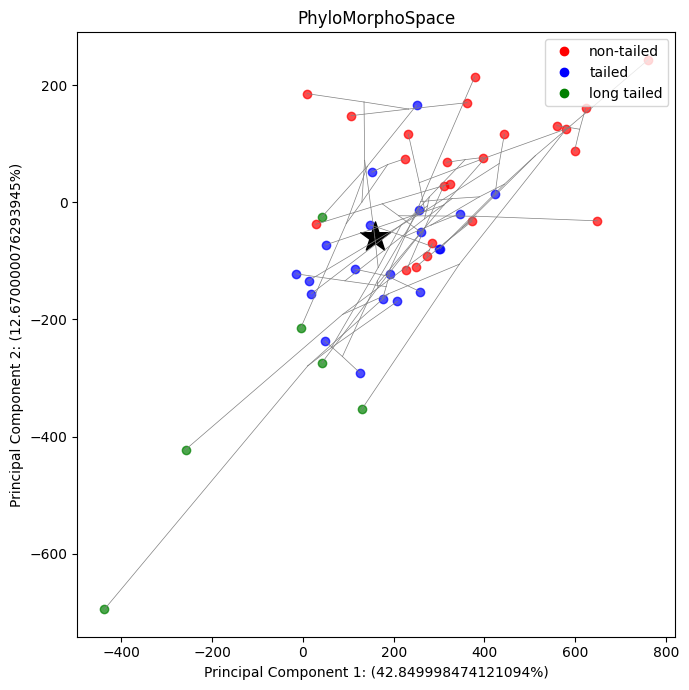

In [15]:
import matplotlib.pyplot as plt
import numpy as np

f = plt.figure(figsize=(7, 7))

col = ["red", "blue", "green"]

# Plot all leaves
for leaf in tree.iter_bfs():
    if leaf.children:
        for child in leaf.children:
            plt.plot([leaf["PCs"][0], child["PCs"][0]], [leaf["PCs"][1], child["PCs"][1]], 'k-', linewidth=0.5,color="grey")
    else:
        #plt.text(leaf["PCs"][0], leaf["PCs"][1], leaf.name, fontsize=8)
        plt.scatter(leaf["PCs"][0], leaf["PCs"][1], color=col[leaf["tailed"]], alpha=0.7)



plt.xlabel(f'Principal Component 1: ({np.round(varexp[0] * 100, 2)}%)')
plt.ylabel(f'Principal Component 2: ({np.round(varexp[1] * 100, 2)}%)')
plt.title('PhyloMorphoSpace')

for color, label in zip(col, ['non-tailed', 'tailed', 'long tailed']):
    plt.plot([], [], 'o', color=color, label=label)

# Plot root
for leaf in tree.iter_bfs():
    if leaf.parent is None:
        plt.scatter(leaf["PCs"][0], leaf["PCs"][1], color='black', marker='*',s=500)


plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

